In [3]:
import pandas as pd
import datetime
import numpy as np 
import pandas_datareader.data as web
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix ##CORRECTION: was not imported and called incorrectly later
from math import ceil  
from sklearn import preprocessing  
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [20]:
#Loading Yahoo Finance dataset
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 9, 1)

df = web.DataReader("JNJ", "yahoo", start, end)
df.tail()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,128.080002,126.629997,127.419998,127.800003,8889500.0,127.800003
2019-08-27,132.399994,129.100006,129.880005,129.639999,20183800.0,129.639999
2019-08-28,128.869995,127.010002,127.860001,128.679993,9878800.0,128.679993
2019-08-29,129.199997,126.830002,128.839996,128.240005,6749900.0,128.240005
2019-08-30,129.100006,127.620003,128.270004,128.360001,7371100.0,128.360001


In [21]:
#Find the rolling mean of the stock
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [22]:
#to better understand rolling mean, let's plot it on matplotlib
import matplotlib.pyplot as plt

from matplotlib import style

In [23]:
#adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

'3.0.2'

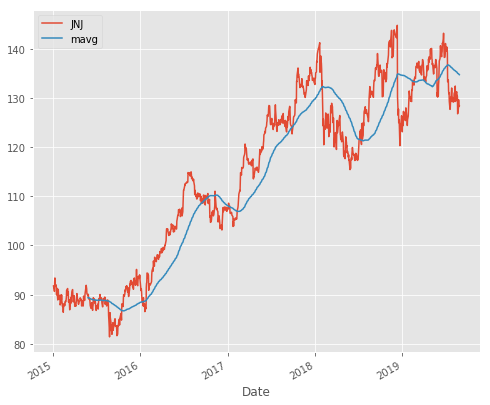

In [19]:
#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='JNJ')
mavg.plot(label='mavg')
plt.legend()

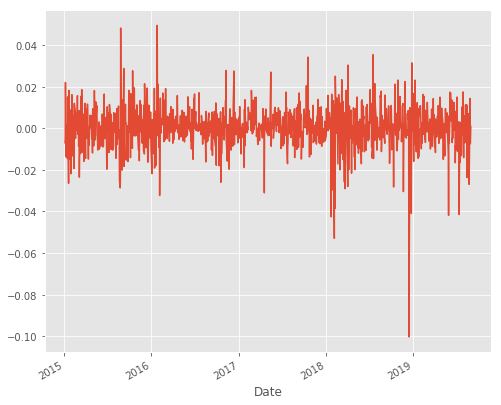

In [24]:
#plot the returns of the stock
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [25]:
#analyzing competitor stocks as well
dfcomp = web.DataReader(['UNH', 'ABT', 'CVS', 'MRK'], 'yahoo', start=start, end=end)['Adj Close']

In [26]:
# run a correlation function to see if any of the stocks are correlated
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

Text(0, 0.5, 'Returns ABT')

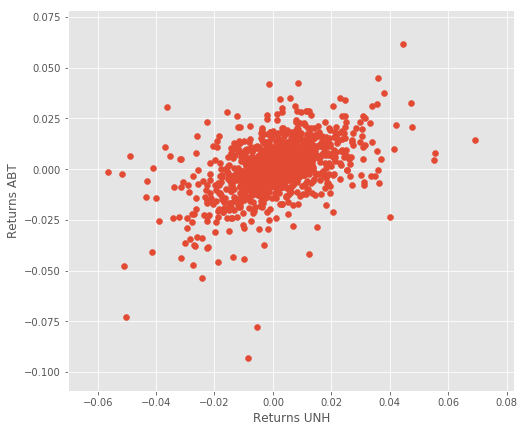

In [27]:
#plotting competitors to see their return distributions
plt.scatter(retscomp.UNH, retscomp.ABT)
plt.xlabel('Returns UNH')
plt.ylabel('Returns ABT')

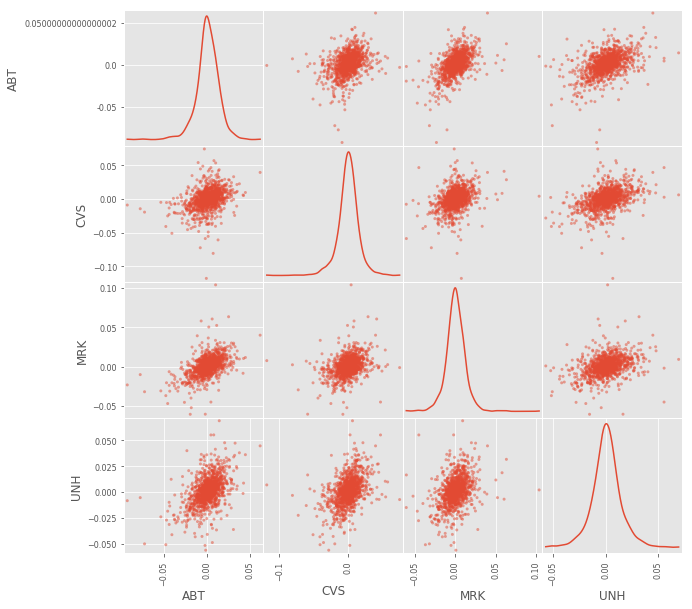

In [28]:
#using Kernel Density Estimate to smooth data and visualize possible correlations
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

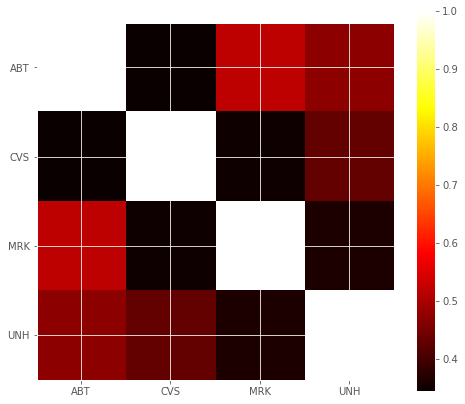

In [29]:
#create a heatmap to prove the positive correlations
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

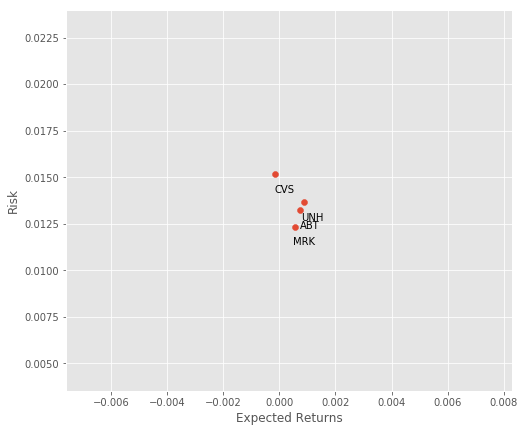

In [31]:
#extracting the average of returns and standard deviation of risk for each stock
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected Returns')
plt.ylabel('Risk')
for label, x, y, in zip(retscomp.columns, retscomp.mean(),
retscomp.std()): 
    plt.annotate(
        label, 
        xy = (x, y),
        textcoords='offset points',
        xytext = (20, -20),  
        ha='right', 
        va='bottom') 

In [2]:
import pandas as pd
import datetime
import numpy as np 
import pandas_datareader.data as web
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix ##CORRECTION: was not imported and called incorrectly later
from math import ceil  
from sklearn import preprocessing  
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



In [6]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 9, 1)
df = web.DataReader('JNJ','yahoo', start, end)
df.tail()
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [7]:
#Drop missing value
dfreg.fillna(value=-99999, inplace = True)
dfreg.dropna(inplace=True)

In [8]:
#separate 1% of the data to forecast
forecast_out = int(ceil(.01 * len(dfreg)))

In [9]:
#predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [10]:
#the same distribution for linear regression
X = preprocessing.scale(X)

#Data Series of late X and early X for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

#Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [12]:
#DEFINING X_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=24)


In [13]:
#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [14]:
#Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [15]:
#Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [16]:
#KNN regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [18]:
#evaluate all of the models against each other
confidencereg = clfreg.score(X_test,y_test)
confidencepoly2 = clfpoly2.score(X_test, y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)


In [21]:
#printing some of the stocks forecasts
forecast_set_reg = clfreg.predict(X_lately)  
forecast_set_poly2 = clfpoly2.predict(X_lately) 
forecast_set_poly3 = clfpoly3.predict(X_lately)  
forecast_set_knn = clfknn.predict(X_lately) 
dfreg['Forecast'] = np.nan

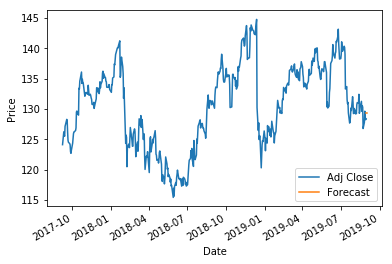

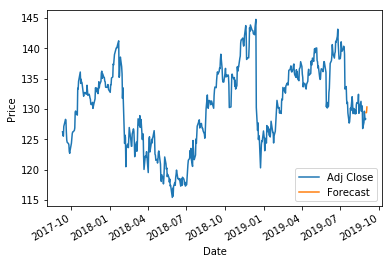

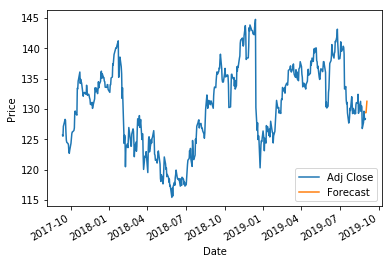

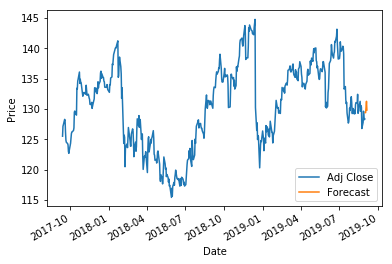

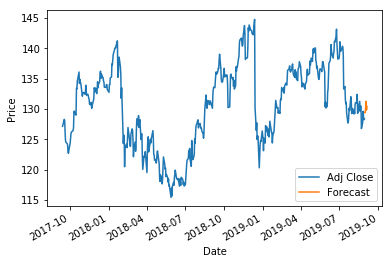

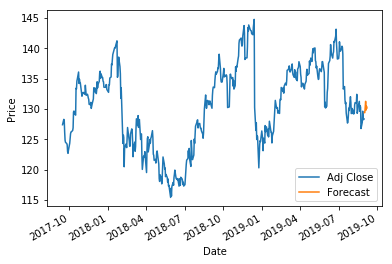

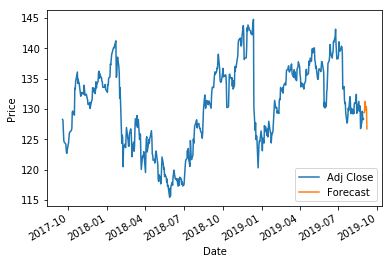

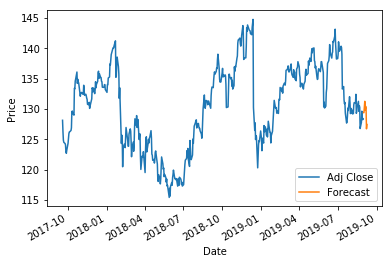

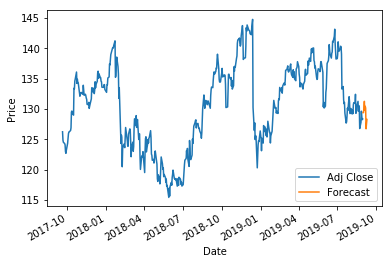

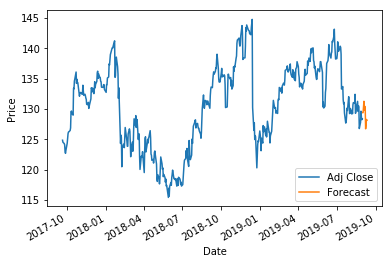

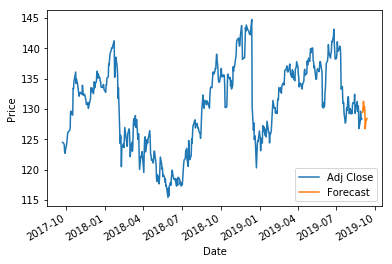

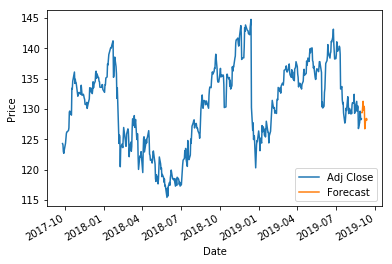

In [23]:
#results
import matplotlib.pyplot as plt
%matplotlib inline

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg: 
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()